# Facial Keypoint Detection
  
This project will be all about defining and training a convolutional neural network to perform facial keypoint detection, and using computer vision techniques to transform images of faces.  The first step in any challenge like this will be to load and visualize the data you'll be working with. 

Let's take a look at some examples of images and corresponding facial keypoints.

<img src='images/key_pts_example.png' width=50% height=50%/>

Facial keypoints (also called facial landmarks) are the small magenta dots shown on each of the faces in the image above. In each training and test image, there is a single face and **68 keypoints, with coordinates (x, y), for that face**.  These keypoints mark important areas of the face: the eyes, corners of the mouth, the nose, etc. These keypoints are relevant for a variety of tasks, such as face filters, emotion recognition, pose recognition, and so on. Here they are, numbered, and you can see that specific ranges of points match different portions of the face.

<img src='images/landmarks_numbered.jpg' width=30% height=30%/>

---

## Load and Visualize Data

The first step in working with any dataset is to become familiar with your data; you'll need to load in the images of faces and their keypoints and visualize them! This set of image data has been extracted from the [YouTube Faces Dataset](https://www.cs.tau.ac.il/~wolf/ytfaces/), which includes videos of people in YouTube videos. These videos have been fed through some processing steps and turned into sets of image frames containing one face and the associated keypoints.

#### Training and Testing Data

This facial keypoints dataset consists of 5770 color images. All of these images are separated into either a training or a test set of data.

* 3462 of these images are training images, for you to use as you create a model to predict keypoints.
* 2308 are test images, which will be used to test the accuracy of your model.

The information about the images and keypoints in this dataset are summarized in CSV files, which we can read in using `pandas`. Let's read the training CSV and get the annotations in an (N, 2) array where N is the number of keypoints and 2 is the dimension of the keypoint coordinates (x, y).

---

In [1]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

In [2]:
key_pts_frame = pd.read_csv('data/training_frames_keypoints.csv')

n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].as_matrix()
key_pts = key_pts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)
print('Landmarks shape: ', key_pts.shape)
print('First 4 key pts: {}'.format(key_pts[:4]))

Image name:  Luis_Fonsi_21.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[  45.   98.]
 [  47.  106.]
 [  49.  110.]
 [  53.  119.]]


# print out some stats about the data

In [3]:
print('Number of images: ', len(key_pts_frame))
print('Number of keypoints per image: ', len(key_pts))

Number of images:  3462
Number of keypoints per image:  68


## Look at some images

Below, is a function `show_keypoints` that takes in an image and keypoints and displays them.  As you look at this data, **note that these images are not all of the same size**, and neither are the faces! To eventually train a neural network on these images, we'll need to standardize their shape.

In [4]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')


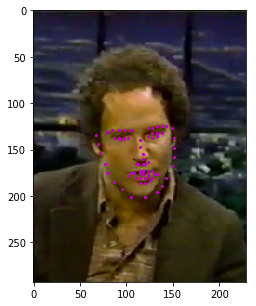

In [5]:
# Display a few different types of images by changing the index n

# select an image by index in our data frame
n = 5
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].as_matrix()
key_pts = key_pts.astype('float').reshape(-1, 2)

plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(os.path.join('data/training/', image_name)), key_pts)
plt.show()

## Dataset class and Transformations

To prepare our data for training, we'll be using PyTorch's Dataset class. Much of this this code is a modified version of what can be found in the [PyTorch data loading tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

#### Dataset class

``torch.utils.data.Dataset`` is an abstract class representing a
dataset. This class will allow us to load batches of image/keypoint data, and uniformly apply transformations to our data, such as rescaling and normalizing images for training a neural network.


Your custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get the i-th sample of image/keypoint data.

Let's create a dataset class for our face keypoints dataset. We will
read the CSV file in ``__init__`` but leave the reading of images to
``__getitem__``. This is memory efficient because all the images are not
stored in the memory at once but read as required.

A sample of our dataset will be a dictionary
``{'image': image, 'keypoints': key_pts}``. Our dataset will take an
optional argument ``transform`` so that any required processing can be
applied on the sample. We will see the usefulness of ``transform`` in the
next section.


In [6]:
from torch.utils.data import Dataset, DataLoader

class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.key_pts_frame.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample

Now that we've defined this class, let's instantiate the dataset and display some images.

In [7]:
# Construct the dataset
face_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                      root_dir='data/training/')

# print some stats about the dataset
print('Length of dataset: ', len(face_dataset))

Length of dataset:  3462


0 (270, 298, 3) (68, 2)
1 (268, 323, 3) (68, 2)
2 (228, 186, 3) (68, 2)


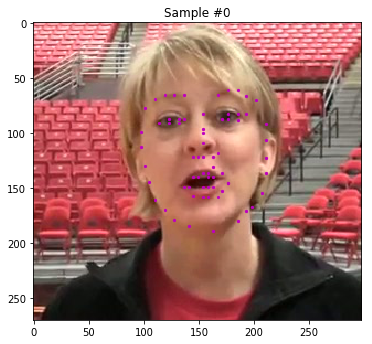

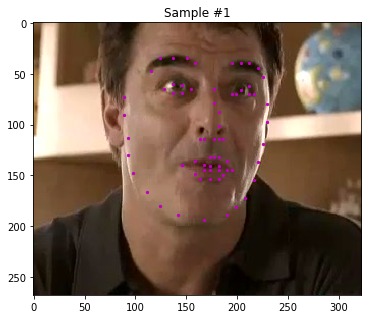

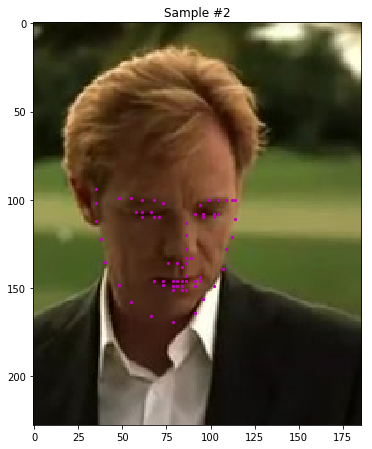

In [8]:
# Display a few of the images from the dataset
num_to_display = 3

for i in range(num_to_display):
    
    # define the size of images
    fig = plt.figure(figsize=(20,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]

    # print the shape of the image and keypoints
    print(i, sample['image'].shape, sample['keypoints'].shape)

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(i))
    
    # Using the same display function, defined earlier
    show_keypoints(sample['image'], sample['keypoints'])


## Transforms

Now, the images above are not of the same size, and neural networks often expect images that are standardized; a fixed size, with a normalized range for color ranges and coordinates, and (for PyTorch) converted from numpy lists and arrays to Tensors.

Therefore, we will need to write some pre-processing code.
Let's create four transforms:

-  ``Normalize``: to convert a color image to grayscale values with a range of [0,1] and normalize the keypoints to be in a range of about [-1, 1]
-  ``Rescale``: to rescale an image to a desired size.
-  ``RandomCrop``: to crop an image randomly.
-  ``ToTensor``: to convert numpy images to torch images.


We will write them as callable classes instead of simple functions so
that parameters of the transform need not be passed everytime it's
called. For this, we just need to implement ``__call__`` method and 
(if we require parameters to be passed in), the ``__init__`` method. 
We can then use a transform like this:

    tx = Transform(params)
    transformed_sample = tx(sample)

Observe below how these transforms are generally applied to both the image and its keypoints.



In [9]:
import torch
from torchvision import transforms, utils
# tranforms

class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 122)/122.0


        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}
    

## Test out the transforms

Let's test these transforms out to make sure they behave as expected. As you look at each transform, note that, in this case, **order does matter**. For example, you cannot crop a image using a value smaller than the original image (and the orginal images vary in size!), but, if you first rescale the original image, you can then crop it to any size smaller than the rescaled size.

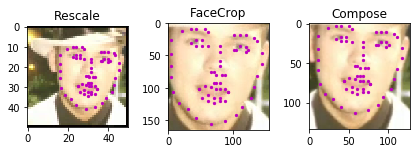

In [11]:
from data_load  import Rescale, RandomCrop, FaceCrop, Normalize, ToTensor, RandomHorizontalFlip, Random90DegFlip

# test out some of these transforms
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
face_cascade
rescale = Rescale(50)
crop = FaceCrop()
composed = transforms.Compose([Rescale(250),
                               FaceCrop(),Rescale(128)])


# apply the transforms to a sample image
test_num = 200
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

## Create the transformed dataset

Apply the transforms in order to get grayscale images of the same shape. Verify that your transform works by printing out the shape of the resulting data (printing out a few examples should show you a consistent tensor size).

In [12]:
# define the data tranform
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


In [13]:
# print some stats about the transformed data
print('Number of images: ', len(transformed_dataset))

# make sure the sample tensors are the expected size
for i in range(100):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'])


Number of images:  3462
0 torch.Size([1, 224, 224]) tensor([[-1.1800,  0.2292],
        [-1.1293,  0.4315],
        [-1.0785,  0.5327],
        [-0.9771,  0.7604],
        [-0.9010,  0.9122],
        [-0.7488,  1.0387],
        [-0.6473,  1.1399],
        [-0.4698,  1.1905],
        [-0.2668,  1.2664],
        [ 0.0122,  1.1399],
        [ 0.1136,  1.0387],
        [ 0.1644,  0.9375],
        [ 0.2658,  0.7857],
        [ 0.2658,  0.5580],
        [ 0.3166,  0.4062],
        [ 0.3166,  0.2545],
        [ 0.2658,  0.0268],
        [-1.0278,  0.0015],
        [-0.9010, -0.0491],
        [-0.7995, -0.0491],
        [-0.6981, -0.0491],
        [-0.5966, -0.0491],
        [-0.2161, -0.0997],
        [-0.1147, -0.1503],
        [ 0.0122, -0.2009],
        [ 0.1136, -0.2009],
        [ 0.2151, -0.1250],
        [-0.3683,  0.0774],
        [-0.3176,  0.2292],
        [-0.3176,  0.3304],
        [-0.3176,  0.4568],
        [-0.4698,  0.5074],
        [-0.4190,  0.5074],
        [-0.3176,  0.558

8 torch.Size([1, 224, 224]) tensor([[-1.0770e+00, -1.4938e-01],
        [-1.0770e+00,  1.8905e-01],
        [-1.0135e+00,  5.0633e-01],
        [-1.0135e+00,  7.6015e-01],
        [-8.6544e-01,  1.0986e+00],
        [-7.3849e-01,  1.4159e+00],
        [-5.4807e-01,  1.6274e+00],
        [-2.9418e-01,  1.8177e+00],
        [ 4.4347e-02,  1.9658e+00],
        [ 4.2519e-01,  1.8389e+00],
        [ 6.1561e-01,  1.7120e+00],
        [ 8.2718e-01,  1.5216e+00],
        [ 1.0176e+00,  1.2466e+00],
        [ 1.0811e+00,  9.9282e-01],
        [ 1.2080e+00,  7.3900e-01],
        [ 1.2715e+00,  4.2172e-01],
        [ 1.2715e+00,  8.3289e-02],
        [-6.7502e-01, -6.4773e-02],
        [-5.4807e-01, -6.4773e-02],
        [-3.5765e-01, -6.4773e-02],
        [-1.6723e-01, -1.3179e-03],
        [-1.9127e-02, -1.3179e-03],
        [ 4.8866e-01,  8.3289e-02],
        [ 6.1561e-01,  1.9834e-02],
        [ 7.6371e-01,  1.9834e-02],
        [ 9.5413e-01,  1.9834e-02],
        [ 1.0811e+00,  1.9834e-02],


15 torch.Size([1, 224, 224]) tensor([[-1.1951, -0.1755],
        [-1.1516,  0.0202],
        [-1.1080,  0.1941],
        [-0.9991,  0.3898],
        [-0.9120,  0.5637],
        [-0.7378,  0.7593],
        [-0.5418,  0.8463],
        [-0.3023,  0.9115],
        [-0.0845,  0.9550],
        [ 0.1115,  0.8245],
        [ 0.1551,  0.6724],
        [ 0.1986,  0.5419],
        [ 0.2422,  0.4115],
        [ 0.2422,  0.2158],
        [ 0.2422,  0.0419],
        [ 0.2422, -0.1537],
        [ 0.1986, -0.3494],
        [-0.8249, -0.3059],
        [-0.6725, -0.3929],
        [-0.5854, -0.4363],
        [-0.4547, -0.4363],
        [-0.3458, -0.4363],
        [-0.0409, -0.4798],
        [ 0.0244, -0.5233],
        [ 0.1115, -0.5668],
        [ 0.1551, -0.5668],
        [ 0.1551, -0.5233],
        [-0.1716, -0.2624],
        [-0.1280, -0.1102],
        [-0.0845,  0.0202],
        [-0.0409,  0.1289],
        [-0.2152,  0.2158],
        [-0.1716,  0.2158],
        [-0.0845,  0.2158],
        [-0.0409,  

21 torch.Size([1, 224, 224]) tensor([[-0.9075,  0.5057],
        [-0.9075,  0.8001],
        [-0.9075,  1.1313],
        [-0.8337,  1.4257],
        [-0.7599,  1.6833],
        [-0.5754,  1.9041],
        [-0.4278,  1.9777],
        [-0.2803,  2.0513],
        [ 0.1256,  2.1617],
        [ 0.4945,  2.0881],
        [ 0.8266,  2.0145],
        [ 1.0480,  1.8673],
        [ 1.2324,  1.6097],
        [ 1.3062,  1.3153],
        [ 1.3800,  0.9841],
        [ 1.3800,  0.6897],
        [ 1.4538,  0.3585],
        [-0.8337,  0.0273],
        [-0.6492, -0.0463],
        [-0.5016, -0.1199],
        [-0.3540, -0.0463],
        [-0.2065, -0.0463],
        [ 0.3470, -0.0463],
        [ 0.4945, -0.1199],
        [ 0.6790, -0.1199],
        [ 0.9004, -0.1199],
        [ 1.0480,  0.0641],
        [ 0.0518,  0.2849],
        [ 0.0518,  0.4321],
        [ 0.0518,  0.6529],
        [ 0.0518,  0.8001],
        [-0.1327,  0.9841],
        [-0.0220,  0.9841],
        [ 0.0518,  1.0577],
        [ 0.1994,  

29 torch.Size([1, 224, 224]) tensor([[-0.5989,  0.1534],
        [-0.6291,  0.4246],
        [-0.6291,  0.6356],
        [-0.6291,  0.8466],
        [-0.5989,  1.1179],
        [-0.5386,  1.3289],
        [-0.4783,  1.4796],
        [-0.3878,  1.6604],
        [-0.1163,  1.8111],
        [ 0.1552,  1.7810],
        [ 0.4266,  1.6604],
        [ 0.6981,  1.5700],
        [ 0.9093,  1.3590],
        [ 0.9998,  1.0877],
        [ 1.0601,  0.8768],
        [ 1.1204,  0.6658],
        [ 1.2109,  0.3945],
        [-0.5386, -0.1179],
        [-0.4783, -0.1480],
        [-0.3878, -0.1480],
        [-0.2671, -0.0877],
        [-0.1766, -0.0576],
        [ 0.2758,  0.0027],
        [ 0.3663,  0.0027],
        [ 0.4870,  0.0328],
        [ 0.6378,  0.0630],
        [ 0.7886,  0.1232],
        [ 0.0043,  0.2739],
        [-0.0560,  0.4246],
        [-0.1766,  0.6055],
        [-0.1766,  0.6959],
        [-0.2068,  0.8165],
        [-0.2068,  0.8466],
        [-0.1163,  0.8466],
        [-0.0560,  

34 torch.Size([1, 224, 224]) tensor([[-0.9737,  0.0410],
        [-0.8687,  0.3029],
        [-0.7637,  0.5124],
        [-0.7111,  0.7742],
        [-0.5536,  1.0361],
        [-0.4485,  1.2455],
        [-0.2910,  1.3503],
        [-0.1334,  1.4026],
        [ 0.2342,  1.5074],
        [ 0.5494,  1.3503],
        [ 0.7595,  1.1932],
        [ 0.8120,  0.9837],
        [ 0.9170,  0.7742],
        [ 0.9695,  0.4600],
        [ 0.9695,  0.3029],
        [ 0.9695,  0.0410],
        [ 0.9695, -0.2208],
        [-0.8687, -0.2208],
        [-0.7637, -0.2732],
        [-0.6061, -0.3255],
        [-0.5011, -0.3255],
        [-0.3435, -0.3255],
        [ 0.0767, -0.4303],
        [ 0.2342, -0.4303],
        [ 0.3393, -0.4303],
        [ 0.5494, -0.4303],
        [ 0.6544, -0.3779],
        [-0.1334, -0.1161],
        [-0.0284,  0.0934],
        [-0.0284,  0.2505],
        [ 0.0242,  0.4076],
        [-0.1334,  0.5124],
        [-0.0284,  0.5124],
        [ 0.0767,  0.5124],
        [ 0.1292,  

42 torch.Size([1, 224, 224]) tensor([[-0.8793, -0.1937],
        [-0.7982,  0.0225],
        [-0.7982,  0.2657],
        [-0.7440,  0.4279],
        [-0.6899,  0.6711],
        [-0.5817,  0.8332],
        [-0.4735,  0.9684],
        [-0.2841,  1.0765],
        [-0.0676,  1.2116],
        [ 0.2300,  1.0765],
        [ 0.4735,  0.9684],
        [ 0.6358,  0.8603],
        [ 0.7982,  0.6981],
        [ 0.8793,  0.4549],
        [ 0.9334,  0.2387],
        [ 0.9876, -0.0045],
        [ 1.0417, -0.2207],
        [-0.7440, -0.4369],
        [-0.6358, -0.4910],
        [-0.5276, -0.4910],
        [-0.3923, -0.4910],
        [-0.2841, -0.4099],
        [ 0.1759, -0.4099],
        [ 0.2841, -0.4640],
        [ 0.4735, -0.4640],
        [ 0.5817, -0.4640],
        [ 0.7440, -0.4099],
        [-0.0676, -0.1937],
        [-0.0676, -0.0045],
        [-0.0676,  0.1576],
        [-0.0676,  0.2657],
        [-0.2300,  0.4008],
        [-0.1218,  0.4008],
        [-0.0676,  0.4008],
        [ 0.0676,  

52 torch.Size([1, 224, 224]) tensor([[-7.8116e-01, -1.8076e-01],
        [-7.8116e-01,  1.1505e-01],
        [-7.8116e-01,  3.1985e-01],
        [-7.1283e-01,  5.2464e-01],
        [-6.4450e-01,  7.9769e-01],
        [-5.0784e-01,  1.0252e+00],
        [-3.7117e-01,  1.2300e+00],
        [-1.6618e-01,  1.3666e+00],
        [ 1.7547e-01,  1.5258e+00],
        [ 5.3991e-01,  1.4576e+00],
        [ 8.1323e-01,  1.3211e+00],
        [ 1.0182e+00,  1.1845e+00],
        [ 1.2232e+00,  9.7973e-01],
        [ 1.2915e+00,  7.0668e-01],
        [ 1.3827e+00,  4.1086e-01],
        [ 1.4510e+00,  1.3781e-01],
        [ 1.5193e+00, -1.3525e-01],
        [-6.4450e-01, -3.8555e-01],
        [-5.7617e-01, -3.8555e-01],
        [-3.7117e-01, -3.8555e-01],
        [-2.3451e-01, -3.6279e-01],
        [-9.7850e-02, -3.6279e-01],
        [ 4.7157e-01, -2.9453e-01],
        [ 6.0824e-01, -3.6279e-01],
        [ 8.1323e-01, -3.6279e-01],
        [ 1.0182e+00, -2.9453e-01],
        [ 1.1549e+00, -2.0351e-01],

60 torch.Size([1, 224, 224]) tensor([[-9.1470e-01, -6.5940e-01],
        [-8.1400e-01, -4.5860e-01],
        [-7.5806e-01, -2.5780e-01],
        [-6.5736e-01, -5.7007e-02],
        [-5.6785e-01,  8.8013e-02],
        [-3.6645e-01,  2.4419e-01],
        [-1.6506e-01,  3.4459e-01],
        [ 8.1096e-02,  4.0036e-01],
        [ 3.7200e-01,  4.4499e-01],
        [ 6.2934e-01,  4.0036e-01],
        [ 7.7479e-01,  3.1112e-01],
        [ 8.1955e-01,  2.1072e-01],
        [ 9.2025e-01,  9.9253e-03],
        [ 9.7619e-01, -2.3549e-01],
        [ 9.7619e-01, -4.2514e-01],
        [ 9.7619e-01, -6.7055e-01],
        [ 9.7619e-01, -8.7135e-01],
        [-5.1190e-01, -1.1391e+00],
        [-3.6645e-01, -1.2395e+00],
        [-2.2100e-01, -1.2395e+00],
        [-6.4357e-02, -1.2395e+00],
        [ 3.6341e-02, -1.2283e+00],
        [ 4.7270e-01, -1.2729e+00],
        [ 5.7340e-01, -1.2729e+00],
        [ 6.7410e-01, -1.2729e+00],
        [ 8.1955e-01, -1.2729e+00],
        [ 8.7549e-01, -1.1725e+00],

67 torch.Size([1, 224, 224]) tensor([[-0.8295, -0.7208],
        [-0.7734, -0.4673],
        [-0.6470, -0.2138],
        [-0.5207,  0.0397],
        [-0.3943,  0.2228],
        [-0.2680,  0.4200],
        [-0.1416,  0.5467],
        [-0.0293,  0.6734],
        [ 0.2936,  0.6734],
        [ 0.6024,  0.4904],
        [ 0.8551,  0.2510],
        [ 1.0376,  0.0679],
        [ 1.1640, -0.1856],
        [ 1.1640, -0.4954],
        [ 1.1640, -0.7489],
        [ 1.0938, -1.0588],
        [ 1.0376, -1.3122],
        [-0.8997, -1.0306],
        [-0.8997, -1.1573],
        [-0.7734, -1.2137],
        [-0.6470, -1.2137],
        [-0.5909, -1.2700],
        [-0.0855, -1.3967],
        [ 0.0409, -1.4531],
        [ 0.1672, -1.5094],
        [ 0.3497, -1.5657],
        [ 0.5322, -1.5094],
        [-0.2680, -1.0165],
        [-0.2118, -0.8334],
        [-0.2118, -0.6503],
        [-0.2118, -0.4532],
        [-0.2118, -0.3264],
        [-0.2118, -0.3264],
        [-0.0855, -0.3264],
        [-0.0293, -

76 torch.Size([1, 224, 224]) tensor([[-0.1647, -0.9155],
        [-0.2639, -0.6676],
        [-0.1647, -0.4196],
        [-0.1151, -0.2213],
        [-0.0655, -0.0230],
        [-0.0159,  0.2250],
        [ 0.1329,  0.2746],
        [ 0.3313,  0.4233],
        [ 0.6290,  0.5721],
        [ 0.9266,  0.4233],
        [ 1.1746,  0.3737],
        [ 1.4226,  0.1754],
        [ 1.5714,  0.0266],
        [ 1.7202, -0.2213],
        [ 1.7698, -0.4196],
        [ 1.7698, -0.6676],
        [ 1.8194, -0.9155],
        [-0.1647, -1.1634],
        [-0.1151, -1.1634],
        [-0.0159, -1.1634],
        [ 0.1329, -1.1634],
        [ 0.1825, -1.1138],
        [ 0.6290, -1.1138],
        [ 0.7282, -1.1138],
        [ 0.8770, -1.1138],
        [ 1.0258, -1.1138],
        [ 1.2242, -1.1138],
        [ 0.4306, -0.8659],
        [ 0.3810, -0.7172],
        [ 0.3810, -0.5684],
        [ 0.3810, -0.3701],
        [ 0.3313, -0.3205],
        [ 0.3810, -0.3205],
        [ 0.4306, -0.3205],
        [ 0.5298, -

89 torch.Size([1, 224, 224]) tensor([[-0.9724,  0.4738],
        [-0.9003,  0.6417],
        [-0.7803,  0.9057],
        [-0.7083,  1.0977],
        [-0.5883,  1.3376],
        [-0.4203,  1.5296],
        [-0.2763,  1.6496],
        [-0.0363,  1.7215],
        [ 0.2757,  1.7695],
        [ 0.5637,  1.6016],
        [ 0.7558,  1.4096],
        [ 0.8758,  1.2416],
        [ 0.9478,  0.9777],
        [ 0.9478,  0.7377],
        [ 0.9478,  0.4978],
        [ 0.9478,  0.2578],
        [ 0.9478, -0.0061],
        [-0.9003,  0.0898],
        [-0.8523, -0.0301],
        [-0.6603, -0.0781],
        [-0.5403, -0.0781],
        [-0.4203, -0.0061],
        [ 0.0837, -0.1981],
        [ 0.2037, -0.2461],
        [ 0.3237, -0.3181],
        [ 0.4437, -0.3181],
        [ 0.6358, -0.2461],
        [-0.1083,  0.2338],
        [-0.0363,  0.4258],
        [-0.0363,  0.5938],
        [ 0.0117,  0.7857],
        [-0.1083,  0.9057],
        [-0.0363,  0.9057],
        [ 0.0837,  0.9057],
        [ 0.1317,  

98 torch.Size([1, 224, 224]) tensor([[-0.6933, -0.1808],
        [-0.5446,  0.0982],
        [-0.4145,  0.3028],
        [-0.2844,  0.5074],
        [-0.0800,  0.6562],
        [ 0.2731,  0.7865],
        [ 0.5519,  0.8051],
        [ 0.8121,  0.7307],
        [ 1.1652,  0.7307],
        [ 1.4254,  0.5446],
        [ 1.5741,  0.4702],
        [ 1.6484,  0.3400],
        [ 1.7042,  0.0610],
        [ 1.7042, -0.1436],
        [ 1.6484, -0.4226],
        [ 1.5741, -0.6272],
        [ 1.4254, -0.9062],
        [-0.3401, -0.6644],
        [-0.2101, -0.8690],
        [-0.0056, -0.9249],
        [ 0.1245, -0.9993],
        [ 0.2731, -0.9993],
        [ 0.8121, -1.1109],
        [ 0.8864, -1.1853],
        [ 1.0165, -1.2597],
        [ 1.1652, -1.2597],
        [ 1.2953, -1.1853],
        [ 0.6077, -0.8504],
        [ 0.7563, -0.7016],
        [ 0.8121, -0.6458],
        [ 0.8864, -0.4970],
        [ 0.6820, -0.2366],
        [ 0.8121, -0.2366],
        [ 0.8864, -0.2924],
        [ 0.9608, -

## Data Iteration and Batching

Right now, we are iterating over this data using a ``for`` loop, but we are missing out on a lot of PyTorch's dataset capabilities, specifically the abilities to:

-  Batch the data
-  Shuffle the data
-  Load the data in parallel using ``multiprocessing`` workers.

``torch.utils.data.DataLoader`` is an iterator which provides all these
features, and we'll see this in use in the *next* notebook, Notebook 2, when we load data in batches to train a neural network!

---



## Ready to Train!

Now that you've seen how to load and transform our data, you're ready to build a neural network to train on this data.

In the next notebook, you'll be tasked with creating a CNN for facial keypoint detection.